In [163]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import time
import warnings
from wordcloud import WordCloud
%matplotlib inline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import lucem_illud



In [164]:
def get_text(url):
    p = urlopen(url)
    s = BeautifulSoup(p)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    a = len(soup.find_all('p'))
    text = ""
    for i in range(0, a):
        text = text + soup.find_all('p')[i].text + " "
        text = text.replace("\n"," ")
    return text

def get_links(url):
    page = urlopen(url)
    soup = BeautifulSoup(page)
    links = []
    for link in soup.findAll('a', attrs={'href': re.compile("^http://")}):
        links.append(link.get('href'))
    return links

def get_story_url(search_string):
    page = requests.get(search_string)
    soup = BeautifulSoup(page.content)
    links = soup.findAll("a")
    results = []
    for link in  soup.find_all("a",href=re.compile("(?<=/url\?q=)(htt.*://.*)")):
        whole_thing = re.split(":(?=http)",link["href"].replace("/url?q=",""))
        results.append(whole_thing[0].split('&')[0])
    rv = []
    for result in results:
        if "www.vanityfair.com" in result:
            rv.append(result)
    return rv

def get_details(url, data):
    p = urlopen(url)
    s = BeautifulSoup(p)
    img_tags = s.find_all('img')
    t = s.find_all('script', type="application/ld+json")
    d = eval(t[0].contents[0])
    
    if url == "https://www.vanityfair.com/hollywood/2014/06/shailene-woodley-cover":
        author = "Krista Smith"
    else:
        author = d['creator'][0][0]
    try:
        photographer = d['creator'][0][1]
    except:
        pass
    try:
        stylist = d['creator'][0][2]
    except:
        pass
    date = d['dateCreated']
    tags = d['keywords']
    headline = d['headline']
    text = get_text(url)    
    try:
        data['author'].append(author)
    except:
        data['author'].append(" ")


    try:
        data['photographer'].append(photographer)
    except:
        data['photographer'].append(" ")

    try:
        data['stylist'].append(stylist)
    except:
        data['stylist'].append("")
    data['date'].append(date)
    data['tags'].append(tags)
    data['headline'].append(headline)
    data['text'].append(text)
    data['url'] = url

    return data

In [18]:
vf_links_full = pd.read_csv("data/vanity fair links.csv")
vf_links = vf_links_full[:58]

In [20]:
%%time
data = {'author': [], 'photographer': [], 'stylist': [], 'date': [],
       'tags': [], 'headline': [], 'text': [], 'url': []}

for url in vf_links['url'].tolist():
    get_details(url,data)

CPU times: user 13.7 s, sys: 728 ms, total: 14.5 s
Wall time: 54.2 s


In [26]:
data_frame = pd.DataFrame(data)

In [54]:
len(data_frame) == len(vf_links)


True

In [55]:
data_frame['url_check'] = vf_links['url'].tolist()
data_frame['interviewee'] = vf_links['interviewee'].tolist()
data_frame['celeb_gender'] = vf_links['celeb_gender'].tolist()
df = data_frame

In [183]:
male_authors = ["Alec Baldwin","Bruce Handy","Buzz Bissinger","David Kamp","Derek Blasberg","James Fox",
"James Wolcott", "Jim Windolf", "Josh Duboff", "Lawrence Schiller", "Max Chafkin", 
"Michael Schulman", "Mitch Glazer", "Nell Scovell", "Rich Cohen", "Sam Kashner", "Todd Purdum"]

def author_gender(row):
    global male_authors
    if row['author'] in male_authors:
        return 'male'
    return 'female'

def words(row):
    return len(row['text'].split())
df['words'] = df.apply (lambda row: words(row), axis=1 )
df['author_gender'] = df.apply (lambda row: author_gender(row), axis=1 )

In [184]:
df.groupby('author_gender').count()

,author,date,headline,photographer,stylist,tags,text,url,url_check,interviewee,celeb_gender,year,pair,text_length,words
author_gender,,,,,,,,,,,,,,,
female,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
male,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31


In [167]:
df.groupby('celeb_gender').count()

,author,date,headline,photographer,stylist,tags,text,url,url_check,interviewee,author_gender,year,pair
celeb_gender,,,,,,,,,,,,,
female,40,40,40,40,40,40,40,40,40,40,40,40,40
male,18,18,18,18,18,18,18,18,18,18,18,18,18


In [172]:
pd.crosstab(df.author_gender, df.celeb_gender)

celeb_gender,female,male
author_gender,,
female,22,5
male,18,13


In [173]:
df['year'] = df['date'].astype(str).str[0:4]
# check if GQ years add up
df.groupby('year').count()[['author']]

,author
year,
2012,8
2013,10
2014,9
2015,10
2016,10
2017,9
2018,2


In [175]:
df.dropna(subset=['text'], inplace = True)
df['text'] = df['text'].str[:-455] # remove Conde Nast user agreement from each interview

df_fm = df[(df['author_gender'] == "female") & (df['celeb_gender'] == "male")]
df_fm['pair'] = "Female-Male"
df_ff = df[(df['author_gender'] == "female") & (df['celeb_gender'] == "female")]
df_ff['pair'] = "Female-Female"
df_mf = df[(df['author_gender'] == "male") & (df['celeb_gender'] == "female")]
df_mf['pair'] = "Male-Female"
df_mm = df[(df['author_gender'] == "male") & (df['celeb_gender'] == "male")]
df_mm['pair'] = "Male-Male"

df_f = pd.concat([df_mf, df_ff])
df_m = pd.concat([df_fm, df_mm])

df = pd.concat([df_fm,df_ff, df_mf, df_mm])
df['text_length'] = df['text'].str.len()

Text(-8.7,0.5,'Length of Profile')

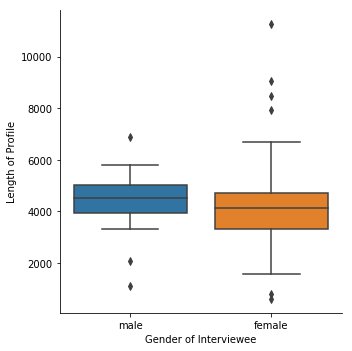

In [190]:
g = sns.factorplot(kind ='box',        # Boxplot
               y = 'words',       # Y-axis - values for boxplot
               x ='celeb_gender',        # X-axis - first factor
               data = df,
               size = 5,            # Figure size (x100px)      
               aspect = 1,        # Width = size * aspect 
               legend_out = False,)
ax = g.axes.flatten()
ax[0].set_xlabel("Gender of Interviewee")
ax[0].set_ylabel("Length of Profile")

In [197]:
df.groupby('year').mean()

,text_length,words
year,,
2012,32260.250000,5661.750000
2013,19805.600000,3477.400000
2014,22816.000000,4012.222222
2015,29109.700000,5096.800000
2016,24663.200000,4303.300000
2017,22837.333333,4043.000000
2018,18584.500000,3199.500000


Text(-8.7,0.5,'Length of Profile')

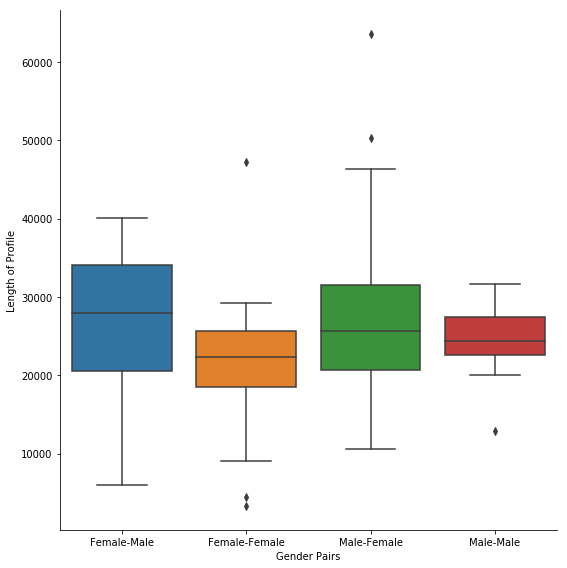

In [192]:
g = sns.factorplot(kind ='box',        # Boxplot
               y = 'text_length',       # Y-axis - values for boxplot
               x ='pair',        # X-axis - first factor
               data = df,
               size = 8,            # Figure size (x100px)      
               aspect = 1,        # Width = size * aspect 
               legend_out = False)  # Make legend inside the plot
ax = g.axes.flatten()
ax[0].set_xlabel("Gender Pairs")
ax[0].set_ylabel("Length of Profile")

In [95]:
original = df



# ALL INTERVIEWS

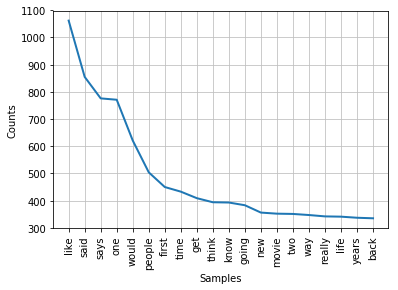

CPU times: user 4.13 s, sys: 22.5 ms, total: 4.15 s
Wall time: 4.17 s


In [96]:
%%time
def freq_dist(df):
    df['tokens'] = df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
    from nltk.corpus import stopwords
    # tokenize
    flatten = lambda l: [item for sublist in l for item in sublist]
    tokens = flatten(flatten(df['tokens'].tolist()))
    # remove stop words
    stopwords = stopwords.words('english')
    clean_tokens = []
    for token in tokens:
        t = token.lower()
        if t not in stopwords and len(t) > 1: # remove stopwords and punctuation
            clean_tokens.append(t)
    freq = nltk.FreqDist(clean_tokens)
    return freq, clean_tokens

freq_all,tokens_all = freq_dist(df)
freq_all.plot(20,cumulative=False)

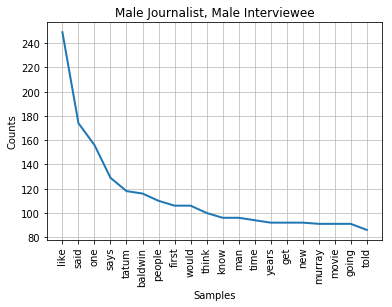

In [288]:
# MALE - MALE
freq_mm,tokens_mm = freq_dist(df_mm)
freq_mm.plot(20,cumulative=False, title = "Male Journalist, Male Interviewee")

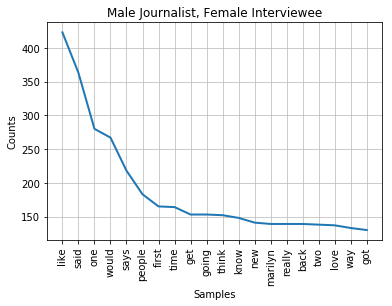

In [289]:
# MALE - FEMALE
freq_mf,tokens_mf = freq_dist(df_mf)
freq_mf.plot(20,cumulative=False, title = "Male Journalist, Female Interviewee")

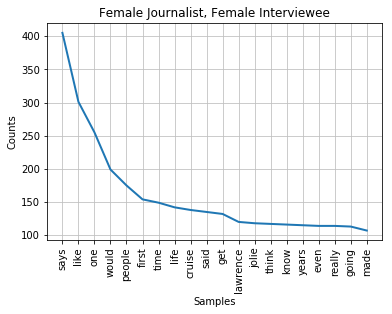

In [290]:
# FEMALE - FEMALE
freq_ff,tokens_ff = freq_dist(df_ff)
freq_ff.plot(20,cumulative=False, title = "Female Journalist, Female Interviewee")

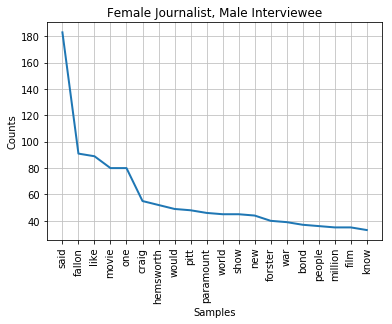

In [291]:
# FEMALE - MALE
freq_fm,tokens_fm = freq_dist(df_fm)
freq_fm.plot(20,cumulative=False, title = "Female Journalist, Male Interviewee")

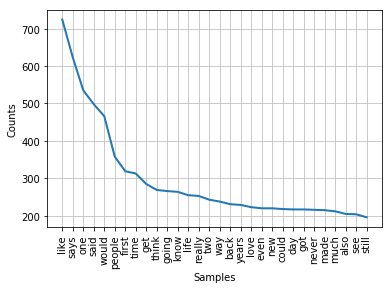

In [169]:
# FEMALE SUBJECTS
freq_f,tokens_f = freq_dist(df_f)
freq_f.plot(30,cumulative=False)

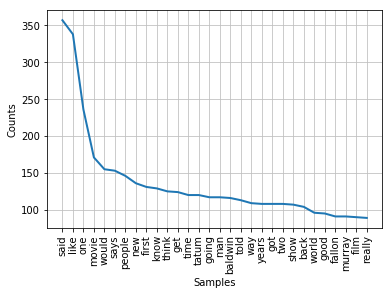

In [170]:
# MALE SUBJECTS
freq_m,tokens_m = freq_dist(df_m)
freq_m.plot(30,cumulative=False)

In [207]:
# test run on mm texts
from nltk import word_tokenize, pos_tag, pos_tag_sents


In [209]:
def top_20(a, entry):
    countTarget = a
    targetCounts = {}
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets


In [241]:
def get_top_20(df, pos):
    texts = df['text'].tolist()
    tagged_texts = pos_tag_sents(map(word_tokenize, texts))
    nouns = top_20(pos,tagged_texts)
    final = []
    for word,count in nouns:
        if len(word) > 2:
            final.append(word)
    return final[:20]

def get_results_df(pos):
    global df_ff, df_mm, df_mf, df_fm
    a = get_top_20(df_ff, pos)
    b = get_top_20(df_mm, pos)
    c = get_top_20(df_mf, pos)
    d = get_top_20(df_fm, pos)
    
    top_nouns = pd.DataFrame(
    {'Female-Female': a,
     'Male-Male': b,
     'Male-Female': c,
     'Female-Male': d})
    
    return top_nouns

In [234]:
a = get_top_20(df_ff, 'NN')

In [235]:
b = get_top_20(df_mm, 'NN')

In [236]:
c = get_top_20(df_mf, 'NN')

In [237]:
d = get_top_20(df_fm, 'NN')

In [238]:
top_nouns = pd.DataFrame(
    {'Female-Female': a,
     'Male-Male': b,
     'Male-Female': c,
     'Female-Male': d})

In [292]:
get_results_df('NN').to_csv("nouns.csv")

In [244]:
get_results_df('VB')

,Female-Female,Female-Male,Male-Female,Male-Male
0,have,have,have,get
1,get,get,get,have
2,make,make,see,make
3,see,see,make,take
4,say,give,say,see
5,take,talk,take,know
6,know,take,tell,think
7,talk,say,feel,play
8,give,come,come,say
9,tell,become,work,want


In [245]:
get_results_df('JJ')

,Female-Female,Female-Male,Male-Female,Male-Male
0,other,other,first,first
1,first,new,other,good
2,last,good,little,other
3,much,first,much,big
4,good,own,new,few
5,next,big,same,little
6,young,famous,good,own
7,own,little,last,last
8,little,same,great,great
9,big,much,few,new


In [115]:
%%time
# see collocations
text = nltk.Text(tokens_all)
text_mm = nltk.Text(tokens_mm)
text_ff = nltk.Text(tokens_ff)
text_mf = nltk.Text(tokens_mf)
text_fm = nltk.Text(tokens_fm)
text_f = nltk.Text(tokens_f)
text_m = nltk.Text(tokens_m)


texts = [text, text_mm, text_ff, text_mf, text_fm, text_f, text_m]
tokens = [tokens, tokens_mm, tokens_ff, tokens_mf, tokens_fm, tokens_f, tokens_m]

CPU times: user 7.98 ms, sys: 709 µs, total: 8.69 ms
Wall time: 8.59 ms


In [274]:
body_parts = ['face','nose','hair','skin','legs','arms','hands','waist','lips', 'leg','arm','hand','lip','breasts',
             'breast','beard','chin','vagina','penis','clitoris', 'smile','chest','butt','ass','biceps','bicep','thigh','thighs']

In [282]:
from collections import Counter

def get_count_dict(df):
    texts = df['text'].tolist()
    flat_list = []
    for text in texts:
        flat_list.extend(text.split())


    to_count = []
    for word in flat_list:
        if word in body_parts:
            to_count.append(word)
    d = {x:to_count.count(x)/len(df) for x in to_count}
    count_average = len(to_count)/len(df)
    return d, count_average

    

In [283]:
get_count_dict(df_mm)

({'arm': 0.3076923076923077,
  'arms': 0.15384615384615385,
  'ass': 0.3076923076923077,
  'beard': 0.23076923076923078,
  'breast': 0.07692307692307693,
  'chin': 0.07692307692307693,
  'face': 1.3076923076923077,
  'hair': 0.3076923076923077,
  'hand': 0.3076923076923077,
  'hands': 0.9230769230769231,
  'leg': 0.07692307692307693,
  'lips': 0.07692307692307693,
  'nose': 0.07692307692307693,
  'smile': 0.23076923076923078},
 4.461538461538462)

In [285]:
get_count_dict(df_mf)

({'arm': 0.16666666666666666,
  'arms': 0.1111111111111111,
  'ass': 0.1111111111111111,
  'beard': 0.1111111111111111,
  'breast': 0.2222222222222222,
  'breasts': 0.2222222222222222,
  'chest': 0.05555555555555555,
  'chin': 0.05555555555555555,
  'face': 1.8888888888888888,
  'hair': 1.4444444444444444,
  'hand': 0.4444444444444444,
  'hands': 0.5,
  'leg': 0.2777777777777778,
  'legs': 0.3888888888888889,
  'lips': 0.16666666666666666,
  'nose': 0.1111111111111111,
  'penis': 0.05555555555555555,
  'skin': 0.2222222222222222,
  'smile': 0.2222222222222222,
  'vagina': 0.05555555555555555},
 6.833333333333333)

In [286]:
get_count_dict(df_ff)

({'arm': 0.045454545454545456,
  'arms': 0.045454545454545456,
  'ass': 0.09090909090909091,
  'breast': 0.13636363636363635,
  'breasts': 0.18181818181818182,
  'chest': 0.09090909090909091,
  'chin': 0.045454545454545456,
  'face': 1.1818181818181819,
  'hair': 1.1818181818181819,
  'hand': 0.5,
  'hands': 0.36363636363636365,
  'leg': 0.09090909090909091,
  'legs': 0.13636363636363635,
  'lip': 0.045454545454545456,
  'lips': 0.045454545454545456,
  'nose': 0.09090909090909091,
  'penis': 0.045454545454545456,
  'skin': 0.3181818181818182,
  'smile': 0.22727272727272727,
  'thigh': 0.045454545454545456},
 4.909090909090909)

In [284]:
get_count_dict(df_fm)

({'arms': 0.6,
  'biceps': 0.2,
  'face': 0.6,
  'hair': 0.2,
  'hand': 0.4,
  'hands': 0.6,
  'lips': 0.2,
  'penis': 0.2,
  'skin': 0.2,
  'smile': 0.2,
  'thighs': 0.2},
 3.6)

In [293]:
get_count_dict(df_f)

({'arm': 0.1,
  'arms': 0.075,
  'ass': 0.1,
  'beard': 0.05,
  'breast': 0.175,
  'breasts': 0.2,
  'chest': 0.075,
  'chin': 0.05,
  'face': 1.5,
  'hair': 1.3,
  'hand': 0.475,
  'hands': 0.425,
  'leg': 0.175,
  'legs': 0.25,
  'lip': 0.025,
  'lips': 0.1,
  'nose': 0.1,
  'penis': 0.05,
  'skin': 0.275,
  'smile': 0.225,
  'thigh': 0.025,
  'vagina': 0.025},
 5.775)

In [294]:
get_count_dict(df_m)

({'arm': 0.2222222222222222,
  'arms': 0.2777777777777778,
  'ass': 0.2222222222222222,
  'beard': 0.16666666666666666,
  'biceps': 0.05555555555555555,
  'breast': 0.05555555555555555,
  'chin': 0.05555555555555555,
  'face': 1.1111111111111112,
  'hair': 0.2777777777777778,
  'hand': 0.3333333333333333,
  'hands': 0.8333333333333334,
  'leg': 0.05555555555555555,
  'lips': 0.1111111111111111,
  'nose': 0.05555555555555555,
  'penis': 0.05555555555555555,
  'skin': 0.05555555555555555,
  'smile': 0.2222222222222222,
  'thighs': 0.05555555555555555},
 4.222222222222222)

In [118]:
for t in texts:
    print(namestr(t)[0])
    print(t.collocations())

text
new york; los angeles; hunger games; years ago; vanity fair; world
war; little bit; last year; beverly hills; meryl streep; tom cruise;
linings playbook; saturday night; high school; movie star; fox news;
academy award; tonight show; jennifer lawrence; silver linings
None
text_mm
new york; los angeles; magic mike; born run; saturday night; mad men;
virtual reality; van zandt; magic leap; years ago; high school; little
bit; night live; iron man; long island; bill murray; lorne michaels;
first time; st. louis; academy award
None
text_ff
new york; fox news; hunger games; tom cruise; los angeles; vanity
fair; knowledgeable source; years ago; mary poppins; last year;
beverly hills; nizhny novgorod; movie star; social media; sea org;
khmer rouge; hillary clinton; ron hubbard; red sparrow; nicole kidman
None
text_mf
new york; los angeles; hunger games; meryl streep; beverly hills;
dressing room; kramer vs.; linings playbook; vanity fair; olivia pope;
keeping kardashians; vs. kramer; harr

In [119]:
from nltk.collocations import *

def namestr(obj, namespace = globals()):
    return [name for name in namespace if namespace[name] is obj]

def top_bigrams(tokens , n = 10):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens, 10)
    finder.apply_freq_filter(10)
    return finder.score_ngrams (bigram_measures.likelihood_ratio)[:n]

def top_trigrams(tokens, n = 10):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
    return whTrigrams.score_ngrams(trigram_measures.student_t)[:n]

In [121]:
for t in tokens:
    print(namestr(t)[0])
    print(top_trigrams(t))


t
[(('.', '“', 'I'), 24.09526221732773), (('I', '’', 'm'), 22.194556213530056), (('don', '’', 't'), 19.542492606390756), (('It', '’', 's'), 19.194607777189123), (('it', '’', 's'), 19.14754580498389), ((',', '”', 'she'), 18.290162206930972), (('didn', '’', 't'), 17.231633969635276), (('I', 'don', '’'), 15.05628581839581), ((',', '”', 'he'), 14.861256971713106), (('she', '’', 's'), 14.742868077430694)]
tokens_mm
[(('saturday', 'night', 'live'), 3.6055418051417303), (('21', 'jump', 'street'), 2.236066835363485), (('magic', 'mike', 'xxl'), 1.999998358378245), (('robert', 'downey', 'jr.'), 1.9999935390458075), (('new', 'york', 'times'), 1.9999569566775866), (('guide', 'recognizing', 'saints'), 1.7320507669492733), (('santa', 'claus', 'wants'), 1.732050590930989), (('academy', 'award', 'nomination'), 1.7320504555323086), (('robert', 'de', 'niro'), 1.7320501772880206), (('million', 'dollar', 'arm'), 1.7320499782519605)]
tokens_ff
[(('according', 'knowledgeable', 'source'), 2.9999956127576155)

In [122]:
for t in tokens:
    print(namestr(t)[0])
    print(top_bigrams(t))

t
[(('’', 's'), 905.4662091690492), (('’', 't'), 332.1141637458285), (('Condé', 'Nast'), 246.08914938812654), (('(', ')'), 212.21895900119483), (('don', 't'), 193.75608421467717), (('[', ']'), 187.02832561169106), (('I', 'm'), 179.6775159152195), (('”', '“'), 171.72983342385885), (('“', '”'), 160.35207445738334), (('“', 'I'), 157.62953545678081)]
tokens_mm
[(('new', 'york'), 24.19887650333858), (('different', 'different'), 22.630907331719218), (('30', 'rock'), 18.936671692796494), (('gon', 'na'), 13.41924111074481), (('magic', 'mike'), 13.048636505946668), (('mad', 'men'), 12.443972574017417), (('los', 'angeles'), 12.357051187618504), (('little', 'bit'), 11.566911992991203), (('virtual', 'reality'), 10.482882503674848), (('born', 'run'), 10.048987652195555)]
tokens_ff
[(('new', 'york'), 24.787760151472344), (('fox', 'news'), 18.19236565261792), (('kate', 'hillary'), 17.76498374602603), (('mary', 'poppins'), 17.04249466594669), (('tom', 'cruise'), 16.670117603477784), (('hunger', 'games

In [171]:
top_trigrams(df_m)

[(('author', 'date', 'headline'), 0.99609375),
 (('author_gender', 'year', 'text_length'), 0.99609375),
 (('celeb_gender', 'author_gender', 'year'), 0.99609375),
 (('date', 'headline', 'photographer'), 0.99609375),
 (('headline', 'photographer', 'stylist'), 0.99609375),
 (('interviewee', 'celeb_gender', 'author_gender'), 0.99609375),
 (('photographer', 'stylist', 'tags'), 0.99609375),
 (('stylist', 'tags', 'text'), 0.99609375),
 (('tags', 'text', 'url'), 0.99609375),
 (('text', 'url', 'url_check'), 0.99609375)]

In [313]:
def get_double_quotes(df):
    texts = df['text'].tolist()
    count = 0
    for text in texts:
        count += texts[0].count('“')
    return round(count/(2*len(df)))




In [314]:
get_double_quotes(df_mm)

14

In [315]:
get_double_quotes(df_fm)

16

In [316]:
get_double_quotes(df_ff)

28

In [317]:
get_double_quotes(df_mf)

34

In [123]:
corpora = [tokens_mm, tokens_mf, tokens_ff, tokens_fm]
stopwords = stopwords.words('english')
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    for word in corpus:
        if word in stopwords:
            s.append(word)
        else:
            nons.append(word)
    corpora_s.append(s)
    corpora_nons.append(nons)
    
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

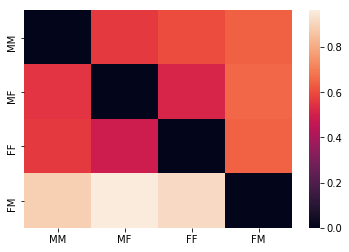

In [126]:
import pandas
import scipy
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = ['MM','MF','FF','FM'], index = ['MM','MF','FF','FM'])
ax = sns.heatmap(div)
plt.show()

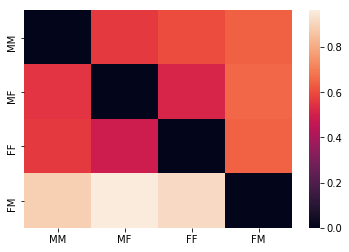

In [127]:
fileids = ['MM','MF','FF','FM']
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

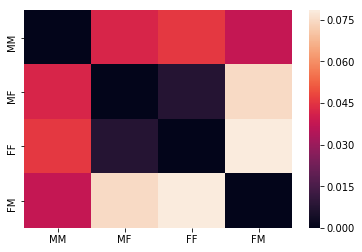

In [128]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

In [129]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

In [130]:
%%time
df = plot_data
# create count vector
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
newsgroupsVects = ngCountVectorizer.fit_transform(df['text'])

# tf-idf
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)

# # vectorize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words='english', norm='l2')
newsgroupsTFVects = ngTFVectorizer.fit_transform(df['text'])


# # k-means
numClusters = 4

km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsgroupsTFVects)

CPU times: user 1.48 s, sys: 26.6 ms, total: 1.51 s
Wall time: 1.53 s


In [131]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 swift
 taylor
 said
 like
 nashville
 apple
 kennedy
 music
 songs
 conor


Cluster 1:
 like
 says
 said
 just
 people
 tatum
 jolie
 don
 time
 think


Cluster 2:
 cruise
 kidman
 scientology
 kashner
 miscavige
 boniadi
 nicole
 tom
 marriage
 river


Cluster 3:
 lawrence
 like
 schumer
 larson
 hemsworth
 jennifer
 kate
 just
 says
 hunger




In [132]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

colordict = {'Male-Male': 'red','Male-Female': 'orange','Female-Female': 'green','Female-Male': 'blue'}
colors = [colordict[c] for c in df['pair']]
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

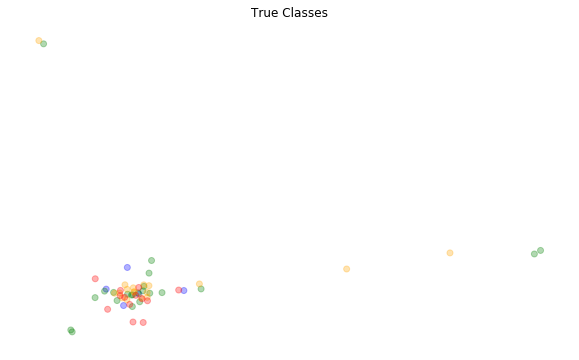

In [320]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
newsgroupsCategories = ['Male-Male', 'Male-Female', 'Female-Female','Female-Male']
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]
#for i, word in enumerate(words):
#    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')

plt.show()


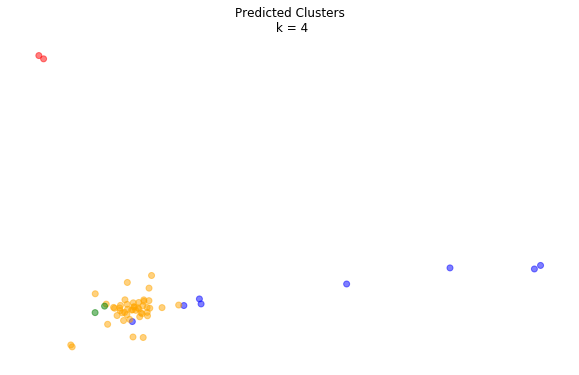

In [136]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [139]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))
    return silhouette_avg

In [140]:
X = newsgroupsTFVects.toarray()



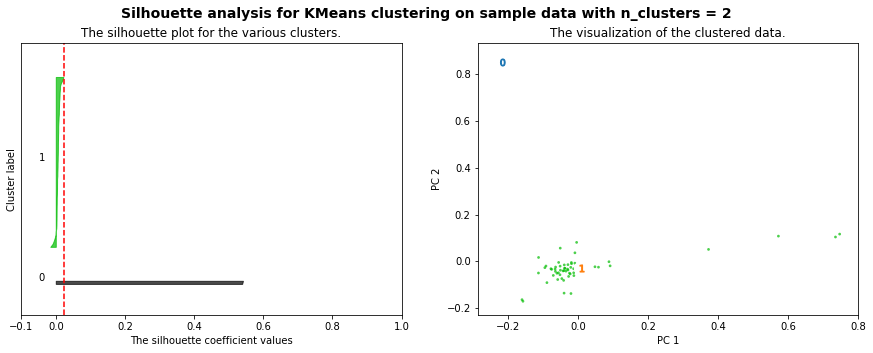

For n_clusters = 2, The average silhouette_score is : 0.024


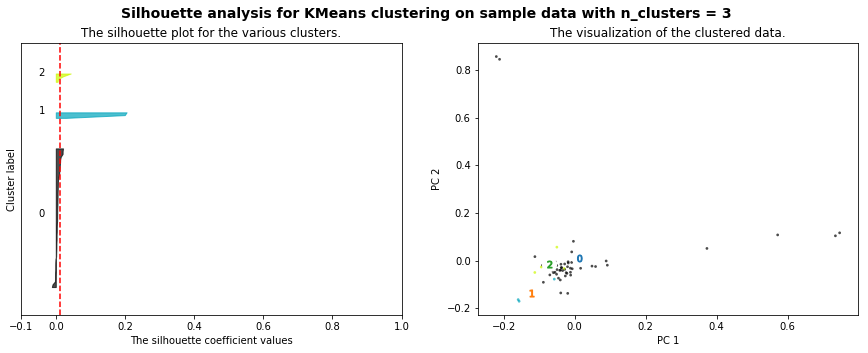

For n_clusters = 3, The average silhouette_score is : 0.013


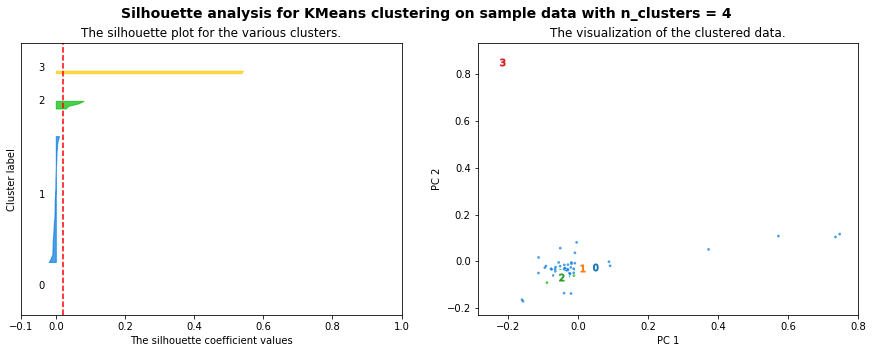

For n_clusters = 4, The average silhouette_score is : 0.019


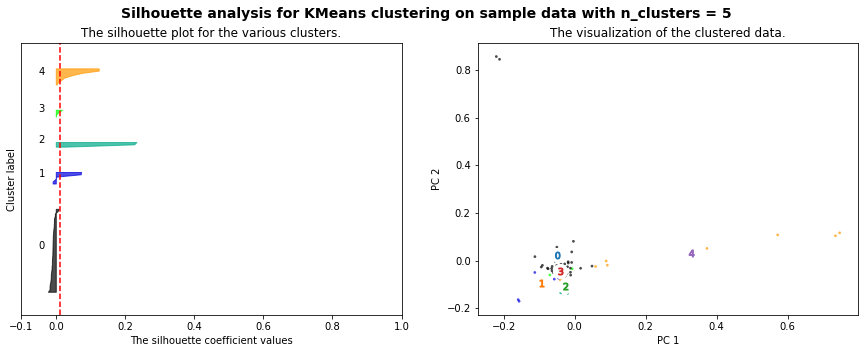

For n_clusters = 5, The average silhouette_score is : 0.012


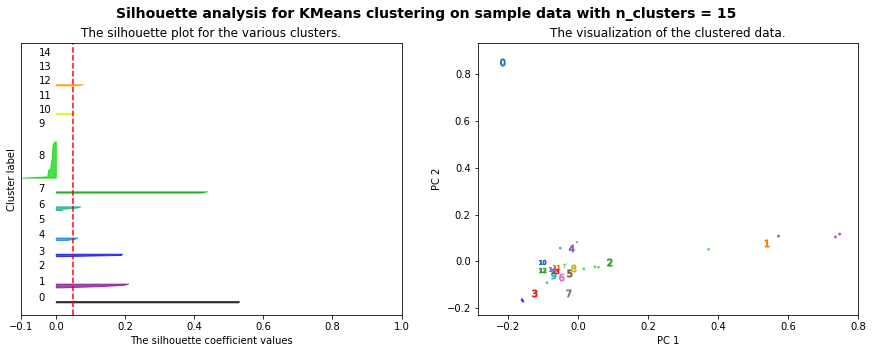

For n_clusters = 15, The average silhouette_score is : 0.050


0.05017283675196637

In [142]:
plotSilhouette(2, X)

plotSilhouette(3, X)

plotSilhouette(4, X)


plotSilhouette(5, X)
plotSilhouette(15, X)




In [159]:
newsgroupsTFVects[:100].todense()
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
df = df.reset_index(drop=True)

selectIndices = []
indexToCat = []
for c in set(df['pair']):
    selectIndices += list(df[df['pair'] == c].index)[:1000]
    indexToCat += [c] * 58
    #.groupby('category').sum()
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())

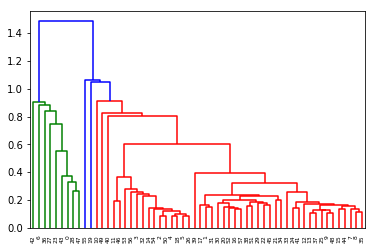

In [160]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)



In [158]:
len(plot_data)

58

In [151]:
#Apply our functions
senReleasesTraining = plot_data

senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=5, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
#senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
#senReleasesTraining.reset_index(inplace = True)
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['headline'][0]))
print("are: {}".format(sen1lda))

The topics of the text: Cover Story: Jennifer Lawrence, A New Light
are: [(1, 0.07560529), (2, 0.8117908), (3, 0.09828325)]


In [152]:
#senReleasesTraining.reset_index(inplace = True)
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['headline'][0]))
print("are: {}".format(sen1lda))

ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['headline'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

The topics of the text: Cover Story: Jennifer Lawrence, A New Light
are: [(1, 0.0636101), (2, 0.8524506), (3, 0.072547965)]


In [154]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]



In [156]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
21,0.000000,0.000000,0.457141,0.125565,0.012706,0,0.152058,0.23602,0.015454,0.0
39,0.000000,0.000000,0.000000,0.000000,0.862595,0,0.103244,0.00000,0.033398,0.0
42,0.000000,0.845991,0.000000,0.000000,0.000000,0,0.148369,0.00000,0.000000,0.0
46,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.00000,0.998886,0.0
51,0.000000,0.000000,0.998354,0.000000,0.000000,0,0.000000,0.00000,0.000000,0.0
0,0.000000,0.058834,0.847682,0.080674,0.000000,0,0.000000,0.00000,0.000000,0.0
1,0.649122,0.114658,0.127667,0.097246,0.010327,0,0.000000,0.00000,0.000000,0.0
2,0.000000,0.575220,0.037073,0.375908,0.000000,0,0.000000,0.00000,0.000000,0.0
3,0.041864,0.000000,0.941372,0.010925,0.000000,0,0.000000,0.00000,0.000000,0.0
5,0.023912,0.052181,0.157583,0.233448,0.015608,0,0.059362,0.00000,0.457515,0.0


In [157]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,like,say,say,like,like,say,like,say,said,like
1,say,like,like,say,said,like,said,like,like,said
2,year,said,said,said,say,said,say,said,say,say
3,want,know,time,want,time,year,want,want,think,year
4,said,year,think,think,year,work,year,know,time,time
5,think,film,make,look,want,look,day,time,know,new
6,make,want,love,know,look,think,know,play,film,look
7,time,look,year,year,work,know,play,look,year,day
8,thing,think,life,way,know,thing,make,thing,want,love
9,play,make,know,time,thing,time,swift,work,thing,know
